# SimpleFormat files exploration and processing
La idea es

* observar estructura de la tabla 
* limpiar aquella cosas que no sean utilizadas
* descartar todos aquellos usuarios que no sean de la telco pues no pueden proveer info de su geolocalizacion. Basicmente los  
* Catalogar las antenas como pertenecientes o no a regiones del *"Gran Chaco"* mejicano

## definiciones utilizadas
* timestamp arranca en 0 segundos para 01/01/2012 00:00am
* el antennaID esta atado solamente al usuario de la TelCo. Los users de la TelCo van todos en la primer columna (independientemente del nombre de la columna..) entonces si la llamada es entrante quiere decir que el user de la telco esta recibiendo un llamado en esa antennaID. si la llamada es saliente es al reves. (Podria pasar que sea comunicaciones inter-Telco y ahi habria dos records uno saliente y otro entrante pero con los mismos 2 userIDs).
* La Direction, viene dada relativa al user de la primer columna (incoming si entra y viceversa si es outgoing).

### el dataset vendria con este header
 {'Target':np.int32 \\\  'Destination':np.uint32 \\\  'TimeStamp':np.uint32 \\\   'Duration':np.uint16 \\\  'AntennaID':np.uint16}

por lo cual seria conveniente eliminar los headers de cada .txt.gz para parsear rapidamente, asignar dtypes y despues volver a asignar column names aca en pandas (u otro program)

In [2]:
import pandas as pd; import numpy as np; import os;import random;
pd.set_option('display.max_rows', 300)
from matplotlib import pyplot as plt
%matplotlib inline
import unicodedata
import gzip
import os

In [3]:
import shutil

In [4]:
np.random.seed(2015)

In [8]:
antennas= pd.read_csv('surrogated_antennas_complete.txt',sep = "|",header=0,index_col=0)
antennas.index.rename("AntennaID",inplace=True) 

In [22]:
tabla = pd.read_csv('datosgeotest/0115/Geo_Voz_Prepago_all_0115.txt.gz',sep = " ", 
              names = ['Target','Destination','Direction','TimeStamp','Duration','AntennaID'],
                             engine = 'c',index_col=None, lineterminator='\n', skipinitialspace=True, 
                    header=None,dtype = {'Target':np.int32,'Destination':np.uint32,'TimeStamp':np.uint32,
                                      'Duration':np.uint16,'AntennaID':np.uint16,'Direction':np.object_})
                    #header=None)

In [20]:
tabla2 = pd.read_csv('datosgeotest/0115/Geo_Voz_Pospago_all_0115.txt.gz',sep = " ", 
              names = ['Target','Destination','Direction','TimeStamp','Duration','AntennaID'],
                             engine = 'c',index_col=None, lineterminator='\n', skipinitialspace=True, 
                    header=None,dtype = {'Target':np.int32,'Destination':np.uint32,'TimeStamp':np.uint32,
                                      'Duration':np.uint16,'AntennaID':np.uint16,'Direction':np.object_})

In [131]:
tabla.sort_values(by='TimeStamp',ascending=True,inplace=True)
tabla2.sort_values(by='TimeStamp',ascending=True,inplace=True)

In [404]:
tabla2.sort_values(by='TimeStamp',ascending=True,inplace=True)

In [23]:
#numero de usuarios en esta tabla
len(np.unique(tabla2.Target.values)), len(np.unique(tabla.Target.values))

(2915274, 4201403)

In [24]:
tabla.shape

(121293306, 6)

In [229]:
#agarro una muestra de 300k para hacer pruebas
sample=tabla.ix[random.sample(tabla.index, 3*(10**5))]
sample2 = tabla.ix[random.sample(tabla.index, 3*(10**5))]

In [234]:
#enriquezco el dataset con la info de antennas_mexico.csv
enriched_sample = pd.merge(sample,antennas,left_on="AntennaID",right_index=True)
enriched_sample2 = pd.merge(sample2,antennas,left_on="AntennaID",right_index=True)

In [239]:
enriched_sample.sort_values(by='TimeStamp',ascending=True,inplace=True)
enriched_sample2.sort_values(by='TimeStamp',ascending=True,inplace=True)

In [240]:
enriched_sample.head()

,Target,Destination,Direction,TimeStamp,Duration,AntennaID,LATITUDE,LONGITUDE,STATE,EPIDEMIC
67561110,1377535,92953080,O,65836808,42,1249,22.145,-101.037,San_Luis_Potosi,0
67426933,1245874,93087787,O,65836809,59,877,20.707,-103.410,Jalisco,1
66574138,611248,70908654,I,65836829,149,1268,19.571,-99.766,Mexico,0
71349316,70606720,70606733,O,65836861,163,2892,19.301,-99.018,Distrito_Federal,0
69275116,8441711,72801178,O,65836926,142,1111,19.646,-99.064,Mexico,0


## Mobility
La idea es ahora mirar dentro de la base (prototipamos con sample) la lista de antenas utilizadas por cada usuario para obtener la variable dependiente $Y$ que vendria a ser si el tipo viajo o no por la zona endemica (visto como un llamado basicamente desde una antena en la epidemic zone). Despues buscaremos atributos, o variables regresoras que logren predecir ese comportamiento en el pasado pero usando solo los atributos en un timeframe "del futuro". Busco atributos que correlacionen con 'haber viajado por la zona endemica en el pasado'
#### pseudocode:
* tomamos el set de origins/targets de la tabla.
* p/c/user lo mapeamos a un conjunto de antenas que sabemos que el tipo uso en algun CDR. Aca usamos alguna operacion split, apply, combine dondeset donde el key va a ser la columna origin y la data es AntennaID. Ahi extraemos la lista de antenas que el user uso. 
* descartamos del dataset los users "vacios". i.e. aquellos que su conjunto de antenas da vacio. Para esto descartamos todas las filas que no tienen ningun user (origin o target) en la tabla split/apply/combine. Asi obtendremos una lista de usuarios de la telco que viajaron por mexico a partir de sus llamados en ese mes. Despues solo hacer un outer join de todas estas tablas resultantes para cada mes. Asi como tambien un join de estos "sets" de antennas por user. 


In [249]:
grouped = tabla['AntennaID'].groupby(tabla['Target'])

In [330]:
#con esto extraigo el mapping user --> antennas used that month
user_antenna_map = sample.groupby('Target')['AntennaID'].apply(lambda x: x.tolist()).to_dict();
user_antenna_map2 = sample2.groupby('Target')['AntennaID'].apply(lambda x: x.tolist()).to_dict();

#esto es 'tipo' un head para dicts
dict(user_antenna_map.items()[0:10]), dict(user_antenna_map2.items()[0:10])

from collections import defaultdict
user_antenna_map_concat = defaultdict(list)

#Veo como concatenar dos "maps" distintos y dejando solo las antenas unicas..
for d in (user_antenna_map, user_antenna_map2): # podemos meter cuantos dicts queramos aca..
    for key, value in d.iteritems():
        #list(set()) elimina repetidos
        user_antenna_map_concat[key] = list(set(user_antenna_map_concat[key] + value))


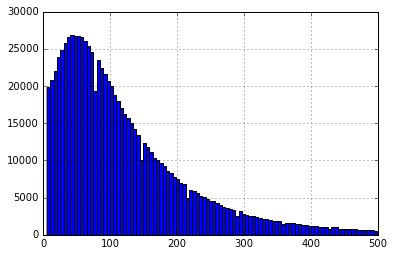

In [397]:
#para observar la distribucion de veces que un usuario llama en un mes.
tabla['Target'].value_counts()[(tabla['Target'].value_counts()>5) & (tabla['Target'].value_counts() < 500)].hist(bins=100)

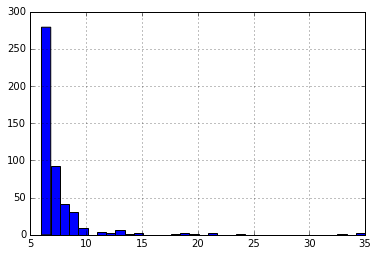

In [400]:
sample['Target'].value_counts()[(sample['Target'].value_counts()>5) & (sample['Target'].value_counts() < 500)].hist(bins=35)

In [ ]:
#con esto extraigo el mapping user --> antennas used that month
user_antenna = tabla.groupby('Target')['AntennaID'].apply(lambda x: x.tolist()).to_dict();
user_antenna2 = tabla.groupby('Target')['AntennaID'].apply(lambda x: x.tolist()).to_dict();

user_antenna_map_concat = defaultdict(list)

#Veo como concatenar dos "maps" distintos y dejando solo las antenas unicas..
for d in (user_antenna_map, user_antenna_map2): # podemos meter cuantos dicts queramos aca..
    for key, value in d.iteritems():
        #list(set()) elimina repetidos
        user_antenna_map_concat[key] = list(set(user_antenna_map_concat[key] + value))


In [100]:
import subprocess
subprocess.call(" echo \"Hello World \" ",shell=True)

0

In [73]:
os.listdir(os.getcwd())    

['Geo_Voz_Prepago_23-241214.txt.gz',
 'Geo_Voz_Prepago_03-041214.txt.gz',
 'Geo_Voz_Prepago_19-201214.txt.gz',
 'Geo_Voz_Prepago_11-121214.txt.gz',
 'Geo_Voz_Prepago_25-261214.txt.gz',
 'Geo_Voz_Prepago_21-221214.txt.gz',
 'Geo_Voz_Prepago_15-161214.txt.gz',
 'Geo_Voz_Prepago_13-141214.txt.gz',
 'Geo_Voz_Prepago_05-061214.txt.gz',
 'Geo_Voz_Prepago_09-101214.txt.gz',
 'Geo_Voz_Prepago_17-181214.txt.gz',
 'Geo_Voz_Prepago_27-281214.txt.gz',
 'Geo_Voz_Prepago_01-021214.txt.gz',
 'Geo_Voz_Prepago_29-311214.txt.gz',
 'Geo_Voz_Prepago_07-081214.txt.gz']

In [106]:
os.chdir(rootdir)
os.walk('.').next()[1]

['1014',
 '0414',
 '0814',
 '0315',
 '0314',
 '0115',
 '0215',
 '0114',
 '0514',
 '0515',
 '1214',
 '0614',
 '0214',
 '0714',
 '0914',
 '1114',
 '0415']

In [88]:
os.chdir(rootdir)
print "testdata" in os.listdir(os.getcwd()) 
if "testdata" in os.listdir(os.getcwd()):
    os.system("mkdir testdata")

False


In [93]:
os.getcwd()

'/home/juan/mobility-study/datosgeo'

In [89]:
os.listdir(os.getcwd())

['output_time.txt',
 '\\',
 '.to_simple_format_mexico.py.swp',
 '1014',
 '0414',
 '0814',
 '0315',
 '0314',
 '0115',
 '0215',
 '0114',
 'output_memory_summary.txt',
 '0514',
 'rename_geodirs_mexico.py',
 'rename_geofiles_mexico.py',
 '0515',
 '1214',
 '0614',
 '0214',
 '0714',
 '0914',
 'to_simple_format_mexico.py',
 '1114',
 '0415']

In [90]:
!ls

0114  0314  0514  0814	1214			   rename_geodirs_mexico.py
0115  0315  0515  0914	\			   rename_geofiles_mexico.py
0214  0414  0614  1014	output_memory_summary.txt  to_simple_format_mexico.py
0215  0415  0714  1114	output_time.txt
